# PROTOCOLO DE TELEPORTACION CUANTICA EN LA ESFERA DE BLOCH.

La teleportacion radica en el hecho de trasferir elmente un estado de un unico qubit (bit cuantico) entre dos partes, usualmente llamados Alice y Bob, empleando un par de qubits preparados en estado de Bell (maximamente entrelazados) que comparten las dos partes. En el protocolo reportado por Bennet et. al. Alice posee un estado cuantico  $\ket{\Psi}_{inicial} = \alpha \ket{0}+ \beta \ket{1}$ , donde $\alpha$ $\beta$ y son desconocidos para Alice. Adicionalmente, ella y Bob comparten el estado de Bell dado por,
   
<center>

$\ket{\Psi}_{+} = \frac{1}{\sqrt{2}}(\ket{0}_A\ket{0}_B + \ket{1}_A\ket{1}_B)$

</center>
Donde los subindices A y B indican si el qubit esta localizado en el subsistema de Alice o de Bob.

1) Se representa el estado inicial de Alice $\ket{\Psi}_{inicial}$ en la esfera de Bloch para 3 conjuntos de parametros, teniendo en cuenta que $|\alpha|^2+|\beta|^2=1$ para el estado normalizado.


    1. $\alpha=\sqrt{0.5}, \beta = \sqrt{0.5}$
    2. $\alpha=\sqrt{0.8}, \beta = \sqrt{0.2}$
    3. $\alpha=\sqrt{0.4}, \beta = \sqrt{0.6}$

In [ ]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=''
)


In [2]:
# Definir los parámetros de los estados iniciales de Alice y Bob

alpha1 = (0.5)**0.5
beta1 = (0.5)**0.5

alpha2 = (0.8)**0.5
beta2 = (0.2)**0.5

alpha3 = (0.4)**0.5
beta3 = (0.6)**0.5

parametros = [[alpha1, beta1], [alpha2, beta2], [alpha3, beta3]]

#Crear los 3 circuitos cuánticos Con 3 qubits y 2 bits clásicos para almacenar los resultados de las mediciones

qreg_names = ['Alice Inicial', 'Alice', 'Bob']
qreg = [[QuantumRegister(1, name=f'{qreg_names[j]}') for j in range(3)] for i in range(3)]
creg = [ClassicalRegister(2, name=f'Mediciones') for i in range(3)]
qc = [QuantumCircuit(*qreg[i], creg[i]) for i in range(3)] 

#Inicializar los estados de Alice y Bob
state = []
for i in range(0,3):
    qc[i].initialize(parametros[i], 0)
    state.append(Statevector(qc[i]))

A continuación se presentan los estados iniciales de cada qubit en cada circuito, donde el primer qubit corresponde al estado inicial de Alice el cual se desea teleportar y los otros dos qubits son los qubits que se comaprtiran por Alice y Bob para formar el estado de Bell $\ket{\Psi}_{+}$, estos por defecto se inicializan en el estado $\ket{0}$.

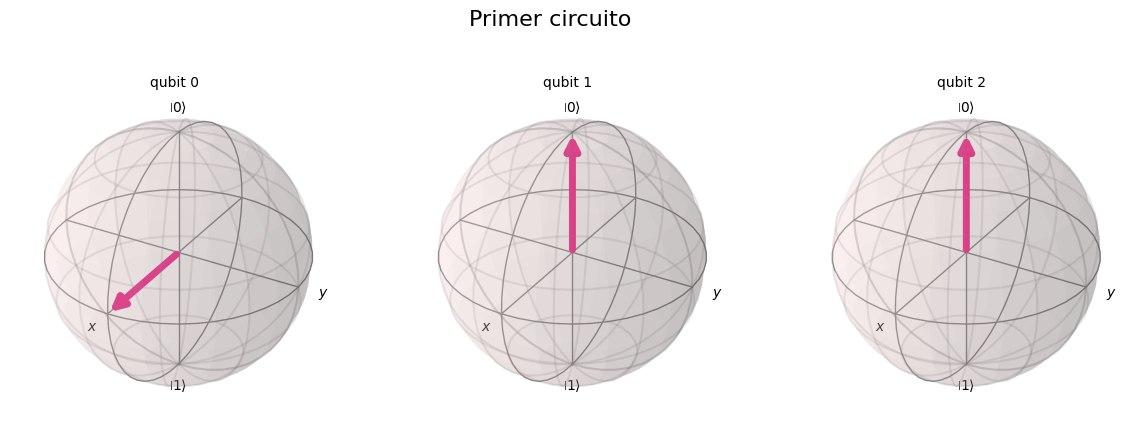

In [3]:
plot_bloch_multivector(state[0], title='Primer circuito')

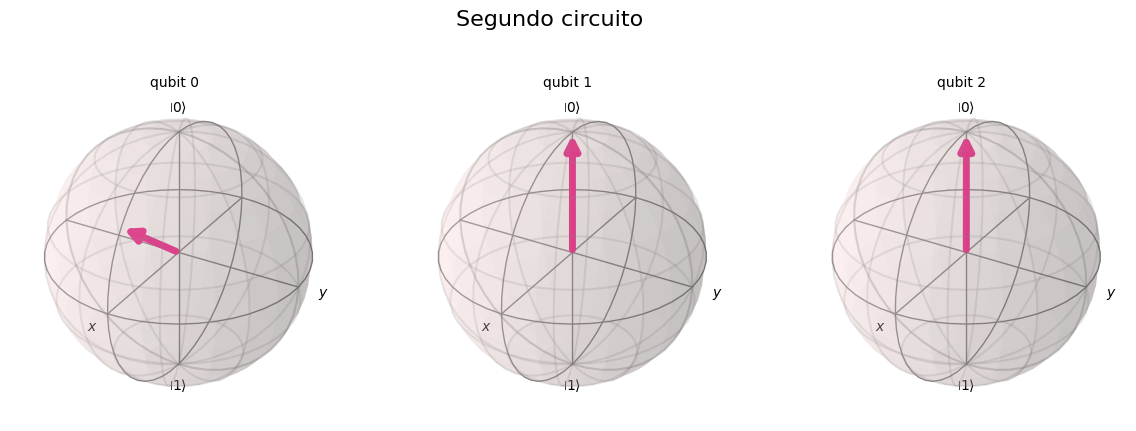

In [4]:
plot_bloch_multivector(state[1], title='Segundo circuito')

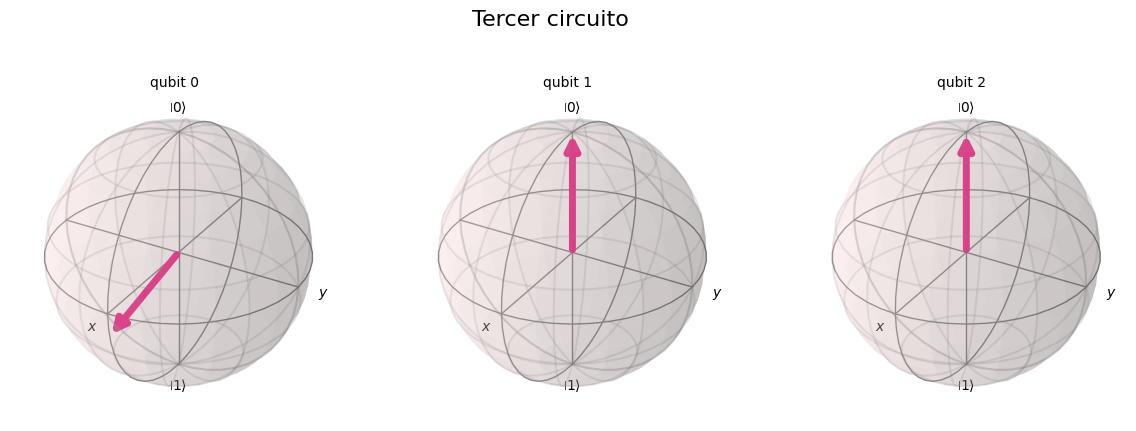

In [5]:
plot_bloch_multivector(state[2], title='Tercer circuito')

2. Obtener el estado cuantico compuesto de tres qubits de los subsistemas de Alice y Bob $\ket{\Psi}_{A,B}=\ket{\Psi_{inicial}}\otimes \ket{\Psi_{+}} $, para esto se entrelaza el segundo qubit de Alice con el de Bob formando el estado de Bell $\ket{\Psi}_{+}$.

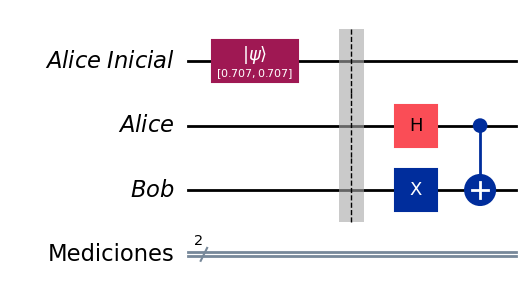

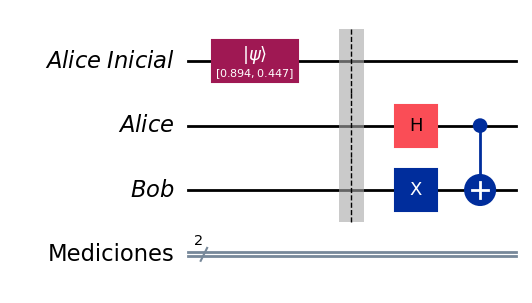

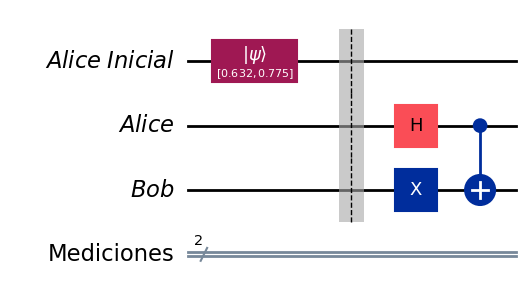

In [6]:
# Aplicar las puertas necesarias para crear el estado de Bell |ψ⟩_+  a cada circuito
for i in range(0,3):
    qc[i].barrier()
    qc[i].x(2)
    qc[i].h(1)
    qc[i].cx(1, 2)

for circuit in qc:
    display(circuit.draw(output='mpl'))

3. Alice debe medir en la base de Bell y así colapsar el estado de los qubits de Bob, para esto se aplica una compuerta de Hadamard y una compuerta de CNOT al estado cuantico compuesto $\ket{\Psi}_{A,B}$. Dependiendo del resultado medido por Alice, Bob deberá aplicar ciertas operaciones a su qubit para recuperar el estado inicial de Alice.

['10', '01', '01']


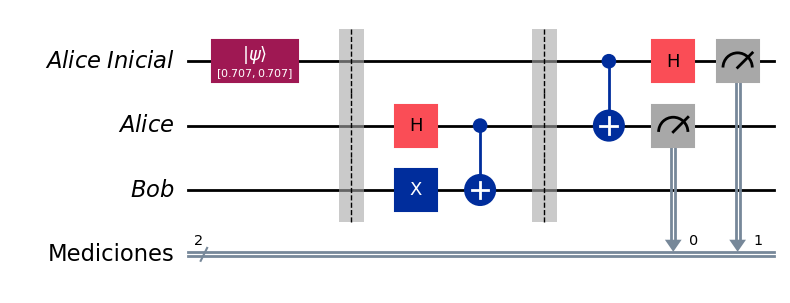

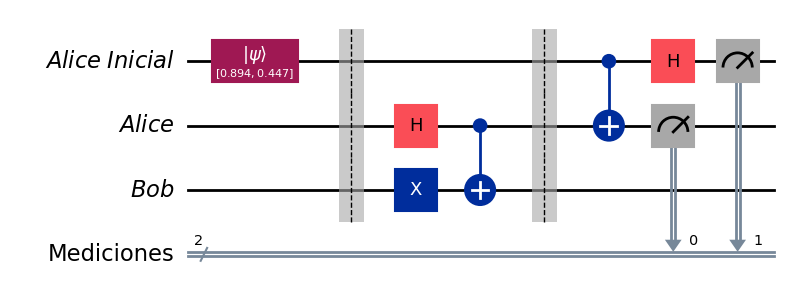

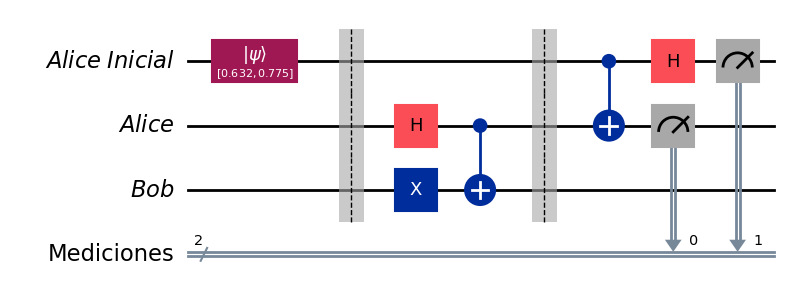

In [7]:
#Realizar la medición en la base de Bell que corresponde a un CNOT y un Hadamard

for i in range(0,3):
    qc[i].barrier()
    qc[i].cx(0, 1)
    qc[i].h(0)
    qc[i].measure([1,0], [0,1])

simulator1 = Aer.get_backend('statevector_simulator')

# Lista para guardar los estados finales de cada circuito en qc
final_states = []
counts = []
for i, circuit in enumerate(qc):

    # Ejecutar y simular el circuito por primera vez
    circ = transpile(circuit, simulator1)
    job = simulator1.run(circ)
    result = job.result()

    
    # Guardar el estado final del circuito
    final_state = result.get_statevector(circ)
    final_states.append(final_state)


    counts.append(result.get_counts())


# Extraer los resultados de las mediciones y guardarlos en una lista
alice = [list(d.keys())[0] for d in counts]

# Mostrar los resultados de las mediciones
print(alice)

for circuit in qc:
    display(circuit.draw(output='mpl'))



4. Una vez Alice obtiene sus resultados y los comparte con Bob, el debera aplicar las compuertas de pauli X o Z, correspondientes para recuperar el estado inicial de Alice. Sin embargo es necesario crear un circuito nuevo ya que al simular el circuito anterior luego no se podrá ver el estado final de Bob en la esfera de Bloch. De modo que se guardaron los estados finales de los qubits y se crean unos nuevos circuitos en los que se inicializan los qubits en los estados finales obtenidos anteriormente.

In [8]:
# Crear una nueva lista de circuitos qc2
qreg_names = ['Alice Inicial', 'Alice', 'Bob']
qreg = [[QuantumRegister(1, name=f'{qreg_names[j]}') for j in range(3)] for i in range(3)]
creg = [ClassicalRegister(2, name=f'Mediciones') for i in range(3)]
qc2 = [QuantumCircuit(*qreg[i], creg[i]) for i in range(3)] 


# Inicializar cada circuito en qc2 con el estado final correspondiente de qc
for i in range(3):
    qc2[i].initialize(final_states[i])

#Aplicar las puertas necesarias para corregir el estado de Bob, dependiendo de las mediciones de Alice
for i in range(0,3):
    qc2[i].barrier()
    if alice[i] == '00':
        qc2[i].x(2)
    elif alice[i] == '11':
        qc2[i].z(2)
    elif alice[i] == '10':
        qc2[i].z(2)
        qc2[i].x(2)

# Ejecutar el nuevo circuito
simulator2 = Aer.get_backend('statevector_simulator')
circ = transpile(qc2, simulator2)
job = simulator2.run(circ)
result = job.result()

# Obtener el vector de estado de cada circuito
statevector = []
for i, circuit in enumerate(circ):
    statevector.append(result.get_statevector(circ[i]))


for i, circuit in enumerate(qc2):
    print(f'El resultado de las medición de Alice en el circuito {i} fue: {alice[i]}')
    display(circuit.draw(output='mpl'))


5. Por último se representa el estado final de Bob en la esfera de Bloch para los 3 conjuntos de parametros dados. Notese que el estado final de Bob (qubit 2) es igual al estado inicial de Alice (qubit 0) que mostramos en el punto 1. al iniciar. Es decir se teleporto el estado cuantico de Alice a Bob.

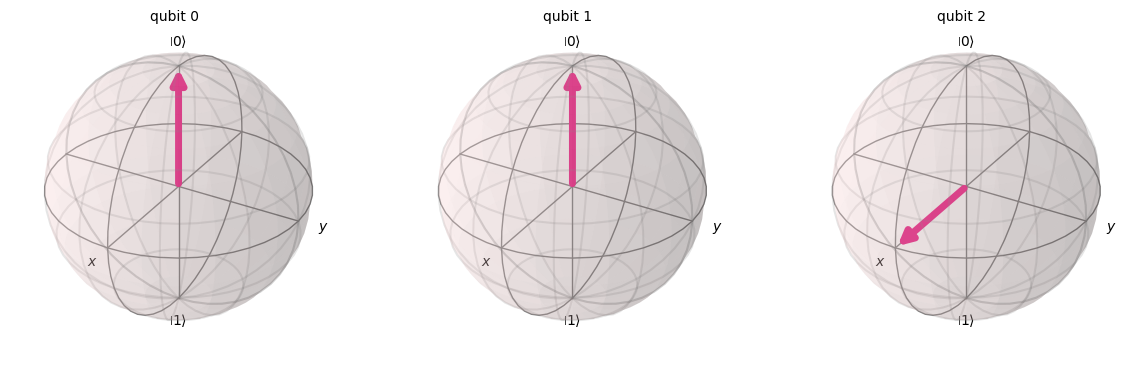

In [ ]:
plot_bloch_multivector(statevector[0], title='Primer circuito teleportado')

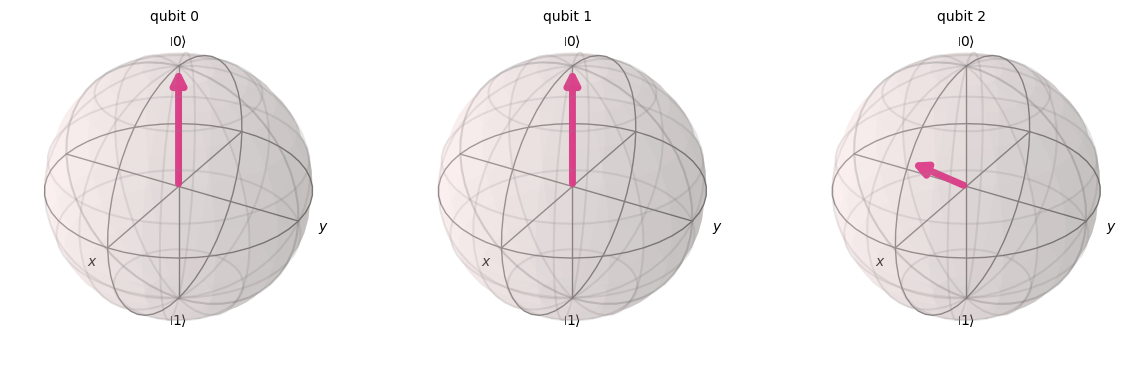

In [ ]:
plot_bloch_multivector(statevector[1], title='Segundo circuito teleportado')

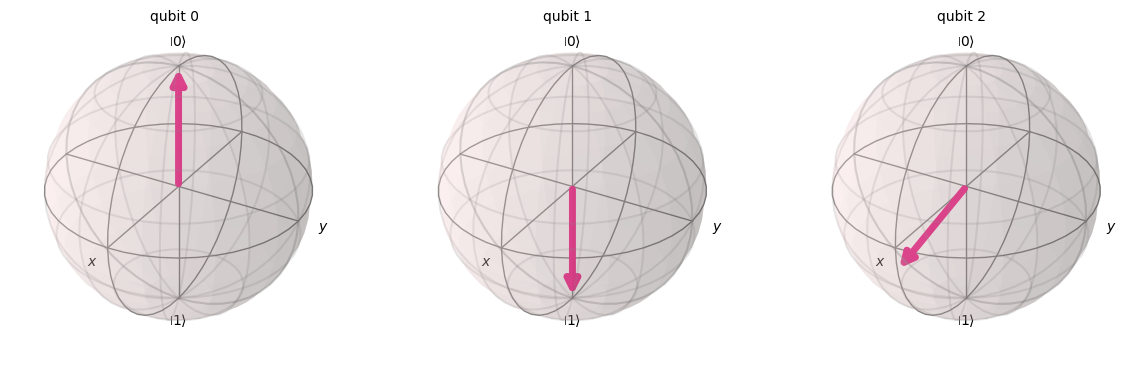

In [ ]:
plot_bloch_multivector(statevector[2], title='Tercero circuito teleportado')